<a href="https://colab.research.google.com/github/denocris/MHPC-DeepLearning-Lectures/blob/master/lec2_sentence_embedding_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>   Word and Sentence Embedding </center> 


<center>  <img src=https://drive.google.com/uc?id=1dsFZ5NWpKcosGPynsbcwQAuQOPgCmxxh  width="800">  </center> 


#### What are we going to learn in this notebook?

* Training a Word2Vec with Gensim on twits 
* Word similarity with Gensim
* Word similarity with Spacy with pre-trained model
* Visualize with t-SDE
* From word embedding to sentence embedding, following this [paper](https://openreview.net/pdf?id=SyK00v5xx) 


## Word Embedding

We need the following ingredients:

* A set of sentences (corpus)

* The vocabulary of corpus (unique tokens)

* The probability of each word in the vocabulary (frequency in the corpus)

* A word vector (embedding) for each word


<center>  <img src=https://drive.google.com/uc?id=18hlhY0pNbLhUlb2vsQnj7a2O8PrUGT2N " width="500">  </center> 

Import basic packages first:

In [0]:
import numpy as np
import pandas as pd
import spacy

#import re # regular expressions

#!pip3 install spacy
#!python3 -m spacy download it

#nlp = spacy.load('it')
#nlp = spacy.load('en')


### Importing the Twitter Tree Bank Dataset (cleaned)

In [0]:
!head -n 10 twitterTreeBank_clean.tsv
! wc -l twitterTreeBank_clean.tsv

sentenceindexsentence
the rock is destined to be the 21st century 's new conan and that he 's going to make a splash even greater than arnold schwarzenegger jeanclaud van damme or steven segal
the gorgeously elaborate continuation of the lord of the rings trilogy is so huge that a column of words can not adequately describe cowriter\director peter jackson 's expanded vision of jrr tolkien 's middleearth
effective but tootepid biopic
if you sometimes like to go to the movies to have fun wasabi is a good place to start
emerges as something rare an issue movie that 's so honest and keenly observed that it does n't feel like one
the film provides some great insight into the neurotic mindset of all comics even those who have reached the absolute top of the game
offers that rare combination of entertainment and education
perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions
steers turns in a snappy screenplay that curls at the edges it 's 

In [0]:
df = pd.read_csv('twitterTreeBank_clean.tsv', sep='\t', header=0)
df.columns = ['sentence']

# count number tokens
numToken = lambda x: x.count(' ') + 1

min_token = 4
max_token = 25

df['length'] = df['sentence'].apply(numToken)
df_min4_max13 = df[df['length'] > min_token - 1]
df_min4_max13 = df_min4_max13[df_min4_max13['length'] < max_token + 1]

#df_min4_max13.groupby('class').count()
df_min4_max13['sentence'][0:10]

2                         effective but tootepid biopic
3     if you sometimes like to go to the movies to h...
4     emerges as something rare an issue movie that ...
5     the film provides some great insight into the ...
6     offers that rare combination of entertainment ...
7     perhaps no picture ever made has more literall...
8     steers turns in a snappy screenplay that curls...
9                           but he somehow pulls it off
10    take care of my cat offers a refreshingly diff...
11    this is a film well worth seeing talking and s...
Name: sentence, dtype: object

### Listing Sentences and build a Corpus

In [0]:
listSentences = list(df_min4_max13['sentence'])
print('Number of sentences: %d' %(len(listSentences)))

merged_sentences = ' '.join(listSentences)
merged_sentences[0:200]

Number of sentences: 9488


"effective but tootepid biopic if you sometimes like to go to the movies to have fun wasabi is a good place to start emerges as something rare an issue movie that 's so honest and keenly observed that "

merged sentences is our corpus

In [0]:
tokens = merged_sentences.split(' ')
tokens[0:50], len(tokens)
#corpus[0:200]
#"'" in token

(['effective',
  'but',
  'tootepid',
  'biopic',
  'if',
  'you',
  'sometimes',
  'like',
  'to',
  'go',
  'to',
  'the',
  'movies',
  'to',
  'have',
  'fun',
  'wasabi',
  'is',
  'a',
  'good',
  'place',
  'to',
  'start',
  'emerges',
  'as',
  'something',
  'rare',
  'an',
  'issue',
  'movie',
  'that',
  "'s",
  'so',
  'honest',
  'and',
  'keenly',
  'observed',
  'that',
  'it',
  'does',
  "n't",
  'feel',
  'like',
  'one',
  'the',
  'film',
  'provides',
  'some',
  'great',
  'insight'],
 139842)

Get frequency of each token:

In [0]:
# we use Counter from collections package
from collections import Counter
tokens_count = Counter(tokens)

For example:

In [0]:
tokens_count.most_common(10)

[('the', 6740),
 ('a', 5313),
 ('and', 4267),
 ('of', 4057),
 ('to', 2692),
 ('is', 2626),
 ("'s", 2442),
 ('it', 2436),
 ('in', 1765),
 ('that', 1700)]

In [0]:
tokens_count['for'], tokens_count['travel'], tokens_count['flight']

(976, 5, 2)

### Build a Vocabulary

Get list of unique tokens, i.e. the vocabulary:

In [0]:
unique_tokens = set(tokens)
vocab_size = len(unique_tokens)
print(vocab_size)

16058


With this list we can put together a dictionary of unique tokens with their probability in the corpus:

In [0]:
# iterating on the keys of tokens_count object, we divide the count of each token by the length of the vocabulary
tokens_prob = {key : tokens_count[key]/len(tokens) for key in tokens_count.keys()}

For example:

In [0]:
tokens_prob['for'] * 100, tokens_prob['travel'] * 100, tokens_prob['flight'] * 100

(0.69793052158865, 0.003575463737646773, 0.0014301854950587091)

Let's check that probabilities sum up to 1.0

In [0]:
sum([tokens_prob[word] for word in unique_tokens])

0.9999999999999046

### Tokenization of sentences

In [0]:
tokenized_sentences = [sent.split(' ') for sent in listSentences]

#tokenized_sentences[0:3]

### Gensim Word2Vec: building a word embedding from our corpus

Next, we train Word2Vec model on our corpus with gensim:

In [0]:
# gensim is used to load word embeddings (install if necessary)
#!pip3 install gensim

from gensim.models import Word2Vec


#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [0]:
vec_size = int(vocab_size ** 0.25) # rule of thumb to decide size of embedding vectors
model = Word2Vec(tokenized_sentences, size=vec_size, window=5, min_count=1, workers=4)
print(vec_size)

11


For example:

In [0]:
model.wv['like'] # show only the first nine values

array([ 0.8313844 ,  0.39017105, -3.424068  , -1.7515198 , -3.3073974 ,
        3.5168483 ,  1.1945553 , -0.6455522 , -5.910732  ,  1.8589202 ,
        1.6304575 ], dtype=float32)

In [0]:
model.wv['love'] # show only the first nine values

array([ 0.4847037 ,  0.43662477, -2.137857  , -1.1476787 , -1.9204389 ,
        2.2054915 ,  0.9703414 , -0.3021955 , -3.7891657 ,  1.0812132 ,
        1.1179516 ], dtype=float32)

In [0]:
model.wv['insight'] # show only the first nine values

array([ 0.09606253,  0.16023746, -0.5341568 , -0.24745269, -0.45723286,
        0.5918025 ,  0.2752594 , -0.10312276, -0.9300168 ,  0.2624269 ,
        0.27388635], dtype=float32)

###  Cosine similariy: measuring how two words are related

Let's understand in a simple case what cosine similarity is

In [0]:
w1 = np.array([0.27,0.36,0.59])
w2 = np.array([0.199,0.83,0.36])

# find cosine
len_a  = sum(v*v for v in w1) ** 0.5             # sqrt(7)
len_b  = sum(v*v for v in w2) ** 0.5             # sqrt(4)
dot    = sum(a*b for a,b in zip(w1, w2))    # 3
cosine = dot / (len_a * len_b)  
cosine

0.8218779528694834

Define it in a more elegant way

In [0]:
def cosine_similarity(w1, w2):
  return np.dot(w1,w2)/(np.dot(w1,w1)*np.dot(w2,w2))**0.5

In [0]:
w1, w2, w3 = 'like', 'love', 'water'

wr1 = model.wv[w1]
wr2 = model.wv[w2]
wr3 = model.wv[w3]


print(cosine_similarity(wr1, wr2), cosine_similarity(wr1, wr3), cosine_similarity(wr2, wr3))


0.9977643942126726 0.9956988942625671 0.9971592098355971



### Testing a Pre-Trained model

In [0]:
import gensim.downloader as api

word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

[==================================================] 100.0% 128.1/128.1MB downloaded


In [0]:
#word_vectors

In [0]:
word_vectors.similarity(w1,w2), word_vectors.similarity(w1,w3), word_vectors.similarity(w2,w3)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


(0.6897015, 0.49640247, 0.31713602)

In [0]:
word_vectors.most_similar('airplane'), word_vectors.most_similar('sea')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


([('plane', 0.8651753067970276),
  ('jet', 0.8155897259712219),
  ('aircraft', 0.7861484289169312),
  ('airplanes', 0.7662244439125061),
  ('airliner', 0.7646356821060181),
  ('jetliner', 0.7469576597213745),
  ('flight', 0.733950138092041),
  ('planes', 0.733876645565033),
  ('flying', 0.7300053834915161),
  ('crash', 0.7099080085754395)],
 [('ocean', 0.8386560082435608),
  ('waters', 0.8161072731018066),
  ('seas', 0.7600178718566895),
  ('mediterranean', 0.7259977459907532),
  ('arctic', 0.697597861289978),
  ('coast', 0.6973382234573364),
  ('atlantic', 0.6909533739089966),
  ('coastal', 0.6893702149391174),
  ('ship', 0.6781935095787048),
  ('gulf', 0.6579795479774475)])

In [0]:
result = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

result = word_vectors.most_similar(positive=['man', 'queen'], negative=['woman'])
print("{}: {:.4f}".format(*result[0]))

result = word_vectors.most_similar(positive=['france', 'rome'], negative=['italy'])
print("{}: {:.4f}".format(*result[0]))



queen: 0.7699
king: 0.7976
paris: 0.8440


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))
print(word_vectors.doesnt_match("obama kennedy trump dylan".split()))
print(word_vectors.doesnt_match("paris milano moscow hamburg madrid cake".split()))

cereal
dylan
cake


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Plotting our Vector Embedding using t-SDE

In [0]:
model_to_plot = Word2Vec(tokenized_sentences, size=vec_size, window=5, min_count=10, workers=4)

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

model = Word2Vec(tokenized_sentences, size=vec_size, window=5, min_count=25, workers=4)
# min_count (int, optional) – Ignores all words with total frequency lower than this.

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


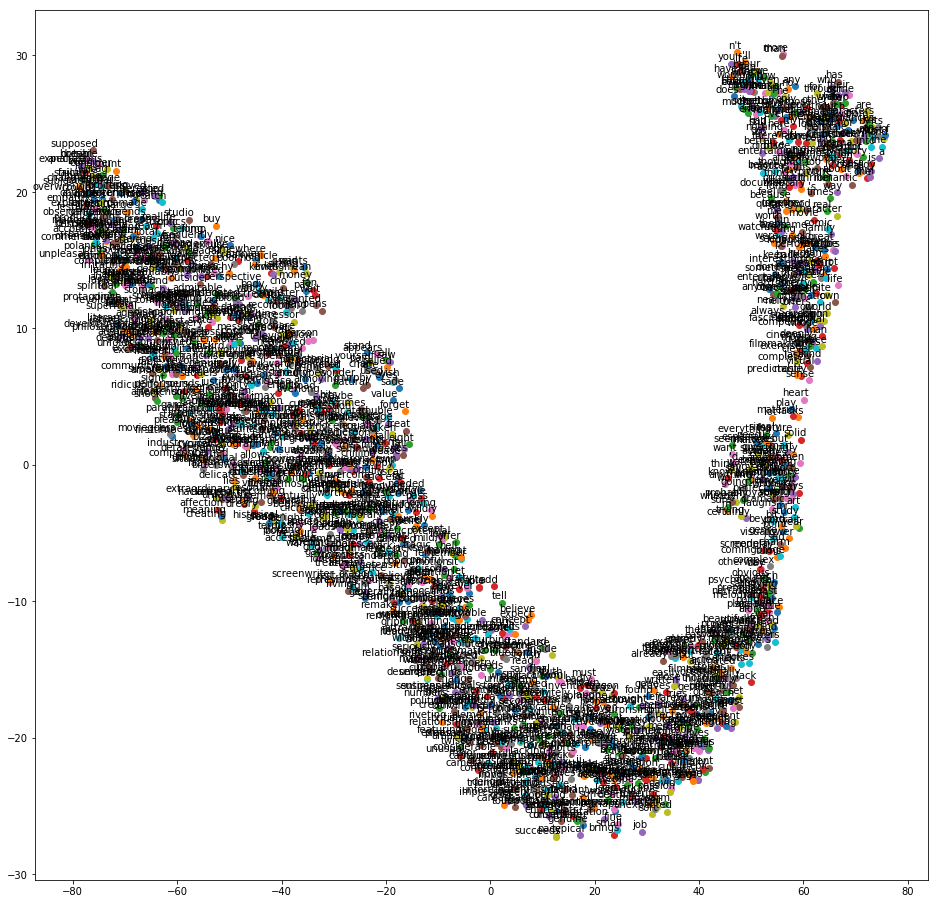

In [0]:
tsne_plot(model_to_plot)

### Use a pre-trained Word2Vec with Spacy

In [0]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 120.9MB 1.2MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqakxaqd/wheels/db/5d/d0/ccdad6b01f9695b4a33793158530b3228223ee31463441663d
Successfully built en-core-web-md

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [0]:
#nlp = spacy.load('en')
import en_core_web_md
#nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_md')

In [0]:
wr1 = nlp('like')
wr2 = nlp('love')
wr3 = nlp('water')

w12 = wr1.similarity(wr2)
w13 = wr1.similarity(wr3)
w23 = wr2.similarity(wr3)

#print(wr1.vector)

w12, w13, w23

(0.6579040236401265, 0.36208879010615413, 0.24938784076850978)

In [0]:
#unique_tokens

In [0]:
#ww=nlp.vocab[u'look']
#ww.vocab
#ww = nlp('look')
#sorted(unique_tokens, key=lambda w: ww.similarity(nlp(w)), reverse=True)

# def most_similar(word):
#     by_similarity = sorted(unique_tokens, key=lambda w: word.similarity(nlp(w)), reverse=True)
#     return [w for w in by_similarity[:10]]
 
# most_similar(nlp(u'aircraft'))

# Sentence Embedding

Let's move to sentence embedding algorithm.

A first prototype on a small corpus, following https://openreview.net/pdf?id=SyK00v5xx.

The basic idea is to compute the sentence vector v_s as a weighted average of the word vectors associated with the words contained in s. The weight of each vector is an inverse function of the probability of the corresponding word in the corpus:

![s_formula](https://drive.google.com/uc?id=1rbDS6cuPPPm05V-6qEnUzX-PPcCYPP6h)

In [0]:
def compute_s_vec(sentence, a=0.001, model_set='OUR_MODEL'): # make sure sentence is tokenized! 
 
    size = vec_size if model_set == 'OUR_MODEL' else 300
    sent_vec = np.zeros(shape=size) # initialize vector of zeros with the wanted shape

    for token in sentence: # cycle through tokens in sentence
        token_p = tokens_prob[token] # probability of token
        if model_set == 'OUR_MODEL':
          token_vec = model.wv[token] # token vector
        else:
          token_vec = nlp(token)
          token_vec = token_vec.vector # token vector
        weighted_token_vec = token_vec*(a/(a+token_p)) # weighted vector of token
        sent_vec = sent_vec + weighted_token_vec # sum

    sent_vec = sent_vec*(1/len(sent_vec)) # average

    return(sent_vec)

For example:

In [0]:
#s1 = compute_s_vec(['you', 'love', 'flying'])
s1 = compute_s_vec(['you', 'love', 'flying'], model_set = 'Spacy')

s1[0:9]

array([ 0.00161874, -0.00206497, -0.00105895, -0.00044943,  0.00055481,
        0.00155123, -0.00111465,  0.00164465, -0.00033959])

In [0]:
#s2 = compute_s_vec(['i', 'really', 'want', 'to', 'fly'])
#s2 = compute_s_vec(['you', 'really', 'love', 'to', 'fly'])
#s2 = compute_s_vec(['she', 'really', 'love', 'flying'])
s2 = compute_s_vec(['she', 'really', 'enjoy', 'to', 'fly'], model_set = 'Spacy')


s2[0:9]

array([ 0.00210899, -0.00010112, -0.00238556, -0.00047998,  0.00192044,
        0.00304599,  0.00081186, -0.00032772, -0.00157144])

In [0]:
#s3 = compute_s_vec(['where', 'are', 'they'])
s3 = compute_s_vec(['where', 'are', 'they'], model_set = 'Spacy')
s3[0:9]

array([ 6.32510930e-04,  5.31924355e-04, -1.29802632e-03, -1.29827504e-03,
        1.15466685e-03, -1.48329884e-05, -1.51372987e-04,  1.10233250e-04,
       -2.78494532e-04])

In [0]:
cosine_similarity(s1, s2), cosine_similarity(s1, s3), cosine_similarity(s2, s3)

(0.8121392931905, 0.5455950135431357, 0.7256512827122583)

Finally, create a dictionary computing vector for each sentence in corpus: